##  **Dogs vs Cats Classification using CNN and Fine-Tuned VGG16**

### Objective
In this lab, fine-tune a pre-trained VGG16 model and compare it against a custom CNN to classify images of cats and dogs.The goal is to explore the effectiveness of transfer learning and analyze both model performance and failure cases.

In [2]:
!pip install matplotlib


  Using cached matplotlib-3.10.1-cp311-cp311-win_amd64.whl (8.1 MB)
  Using cached contourpy-1.3.1-cp311-cp311-win_amd64.whl (219 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     ---------------------------------------- 2.2/2.2 MB 3.6 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.8-cp311-cp311-win_amd64.whl (71 kB)
  Using cached pillow-11.1.0-cp311-cp311-win_amd64.whl (2.6 MB)
  Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install matplotlib seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl (11.6 MB)
  Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks, applications
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
import tensorflow as tf


### Data Loading
Loading images from the `kaggle_dogs_vs_cats_small` dataset which is organized into train, validation, and test folders.


In [3]:
img_height, img_width = 150, 150
batch_size = 32
base_dir = "C:\\Users\\divya\\OneDrive\\Documents\\AI and ML\\S1\\FML\\CSCN8010\\data\\kaggle_dogs_vs_cats_small"


In [4]:

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20,
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Train loader
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

# Validation loader
validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, "validation"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

# Test loader
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=(img_height, img_width),
    batch_size=1,  # For evaluation and predictions
    class_mode='binary',
    shuffle=False
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


### Exploratory Data Analysis (EDA)


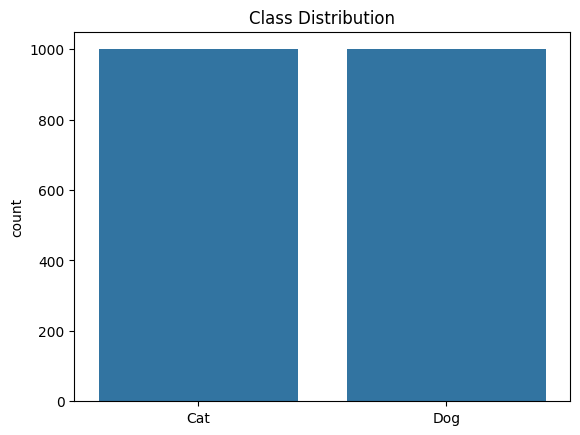

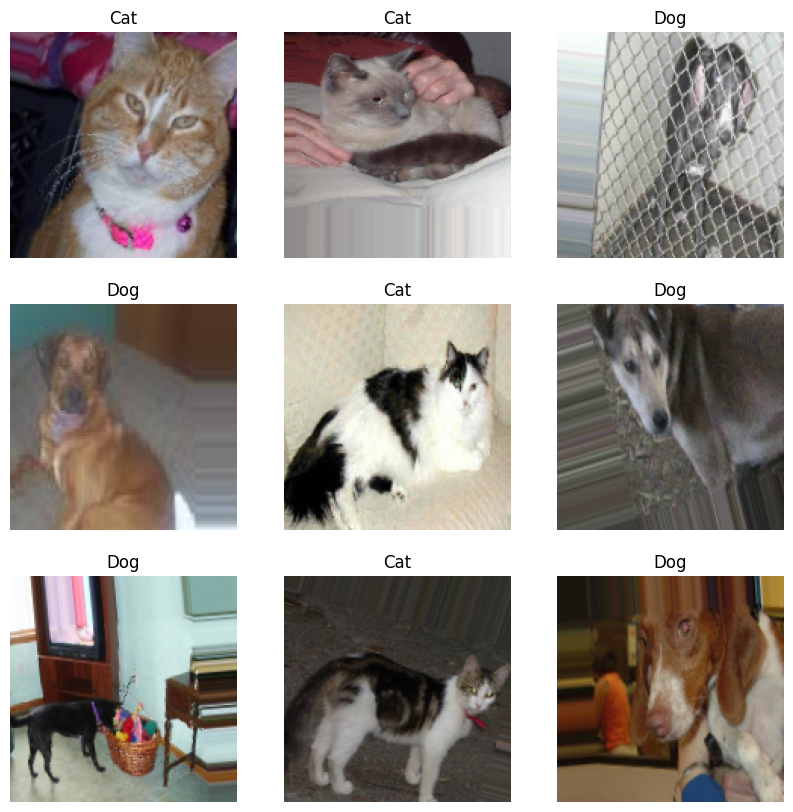

In [10]:
# Class distribution
labels = train_generator.classes
sns.countplot(x=labels)
plt.title("Class Distribution")
plt.xticks([0, 1], ['Cat', 'Dog'])
plt.show()

# Show some images
class_names = ['Cat', 'Dog']
sample_images, sample_labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.title(class_names[int(sample_labels[i])])
    plt.axis("off")
plt.show()


### Model 1 – Custom Convolutional Neural Network (CNN)

In [6]:
def build_custom_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

model_cnn = build_custom_cnn()
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cb = [callbacks.ModelCheckpoint('best_cnn.h5', save_best_only=True),
      callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

history_cnn = model_cnn.fit(train_generator, validation_data=validation_generator,
                            epochs=20, callbacks=cb)


c:\Users\divya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\divya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5093 - loss: 0.8335

63/63 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.5094 - loss: 0.8318 - val_accuracy: 0.5400 - val_loss: 0.6863
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 847ms/step - accuracy: 0.5362 - loss: 0.6887

63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 968ms/step - accuracy: 0.5362 - loss: 0.6887 - val_accuracy: 0.5490 - val_loss: 0.6829
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.5354 - loss: 0.6964 - val_accuracy: 0.5550 - val_loss: 0.6854
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 845ms/step - accuracy: 0.5512 - loss: 0.6849

63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 968ms/step - accuracy: 0.5512 - loss: 0.6850 - val_accuracy: 0.5680 - val_loss: 0.6772
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.5564 - loss: 0.6855

63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 710ms/step - accuracy: 0.5565 - loss: 0.6855 - val_accuracy: 0.6330 - val_loss: 0.6504
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 817ms/step - accuracy: 0.5678 - loss: 0.6804 - val_accuracy: 0.5380 - val_loss: 0.6895
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.5716 - loss: 0.6758

63/63 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.5718 - loss: 0.6758 - val_accuracy: 0.6460 - val_loss: 0.6438
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - accuracy: 0.6092 - loss: 0.6577

63/63 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.6093 - loss: 0.6578 - val_accuracy: 0.6450 - val_loss: 0.6412
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - accuracy: 0.6346 - loss: 0.6346

63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 961ms/step - accuracy: 0.6347 - loss: 0.6346 - val_accuracy: 0.6230 - val_loss: 0.6131
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.6549 - loss: 0.6238

63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 638ms/step - accuracy: 0.6547 - loss: 0.6240 - val_accuracy: 0.6410 - val_loss: 0.6131
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 571ms/step - accuracy: 0.6701 - loss: 0.6186 - val_accuracy: 0.6260 - val_loss: 0.6296
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 591ms/step - accuracy: 0.6764 - loss: 0.6246 - val_accuracy: 0.6180 - val_loss: 0.7747
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 622ms/step - accuracy: 0.6616 - loss: 0.6266 - val_accuracy: 0.6200 - val_loss: 0.6658
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.6260 - loss: 0.6512

63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 590ms/step - accuracy: 0.6264 - loss: 0.6510 - val_accuracy: 0.6910 - val_loss: 0.5805
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.6829 - loss: 0.6015

63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 538ms/step - accuracy: 0.6831 - loss: 0.6013 - val_accuracy: 0.7120 - val_loss: 0.5510
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 569ms/step - accuracy: 0.7135 - loss: 0.5760 - val_accuracy: 0.6970 - val_loss: 0.5775
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 563ms/step - accuracy: 0.7104 - loss: 0.5578 - val_accuracy: 0.6990 - val_loss: 0.5610
Epoch 18/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 573ms/step - accuracy: 0.6917 - loss: 0.5774 - val_accuracy: 0.7190 - val_loss: 0.5511
Epoch 19/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.7272 - loss: 0.5494

63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 584ms/step - accuracy: 0.7271 - loss: 0.5495 - val_accuracy: 0.7330 - val_loss: 0.5369
Epoch 20/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.7303 - loss: 0.5584

63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 609ms/step - accuracy: 0.7303 - loss: 0.5582 - val_accuracy: 0.7280 - val_loss: 0.5264


### Model 2 – Fine-Tuned VGG16

In [8]:
base_model = applications.VGG16(weights='imagenet', include_top=False,
                                input_shape=(img_height, img_width, 3))
base_model.trainable = False

model_vgg = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model_vgg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cb_vgg = [callbacks.ModelCheckpoint('best_vgg.h5', save_best_only=True),
          callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

history_vgg = model_vgg.fit(train_generator, validation_data=validation_generator,
                            epochs=20, callbacks=cb_vgg)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 50s 1us/step
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6153 - loss: 1.0559

63/63 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.6167 - loss: 1.0502 - val_accuracy: 0.8710 - val_loss: 0.3143
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7972 - loss: 0.4225

63/63 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.7973 - loss: 0.4224 - val_accuracy: 0.8980 - val_loss: 0.2723
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 0.8272 - loss: 0.3865 - val_accuracy: 0.8860 - val_loss: 0.2761
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8354 - loss: 0.3637

63/63 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.8353 - loss: 0.3638 - val_accuracy: 0.8990 - val_loss: 0.2556
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.8517 - loss: 0.3255 - val_accuracy: 0.9020 - val_loss: 0.2584
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 249s 3s/step - accuracy: 0.8379 - loss: 0.3399 - val_accuracy: 0.8970 - val_loss: 0.2599
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.8649 - loss: 0.3280 - val_accuracy: 0.8980 - val_loss: 0.2582
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8599 - loss: 0.3134

63/63 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.8599 - loss: 0.3135 - val_accuracy: 0.9020 - val_loss: 0.2383
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.8613 - loss: 0.3153 - val_accuracy: 0.9040 - val_loss: 0.2420
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8457 - loss: 0.3428

63/63 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.8459 - loss: 0.3424 - val_accuracy: 0.9080 - val_loss: 0.2365
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8713 - loss: 0.3024

63/63 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.8713 - loss: 0.3024 - val_accuracy: 0.9120 - val_loss: 0.2339
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.8714 - loss: 0.2820 - val_accuracy: 0.9110 - val_loss: 0.2347
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.8727 - loss: 0.3014 - val_accuracy: 0.8930 - val_loss: 0.2551
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.8688 - loss: 0.3009 - val_accuracy: 0.9070 - val_loss: 0.2401
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.8703 - loss: 0.2833 - val_accuracy: 0.9110 - val_loss: 0.2365
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.8674 - loss: 0.3128 - val_accuracy: 0.9010 - val_loss: 0.2523


### Model Evaluation

In [8]:
from tensorflow.keras.models import load_model

model_cnn = load_model('best_cnn.h5')
model_vgg = load_model('best_vgg.h5')


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step
--- Custom CNN ---
              precision    recall  f1-score   support

         Cat       0.78      0.61      0.68      1000
         Dog       0.68      0.83      0.75      1000

    accuracy                           0.72      2000
   macro avg       0.73      0.72      0.71      2000
weighted avg       0.73      0.72      0.71      2000



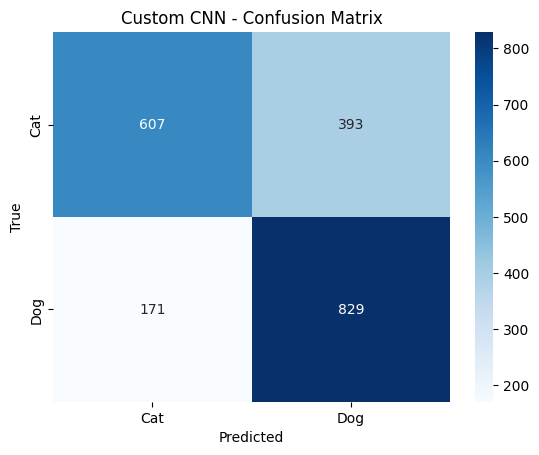

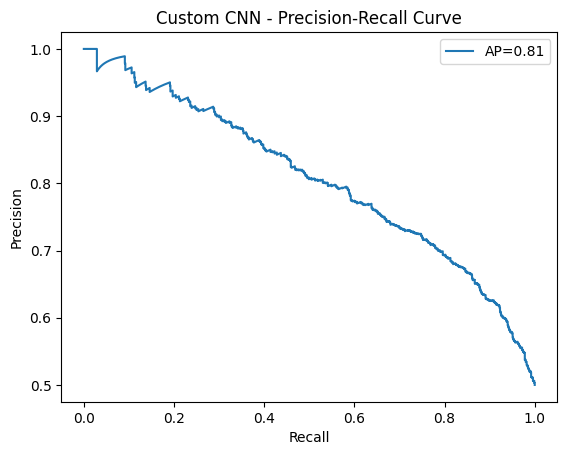

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 225s 112ms/step
--- Fine-Tuned VGG16 ---
              precision    recall  f1-score   support

         Cat       0.91      0.89      0.90      1000
         Dog       0.89      0.91      0.90      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



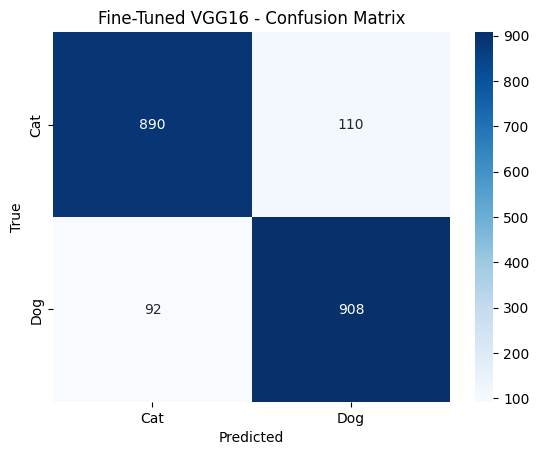

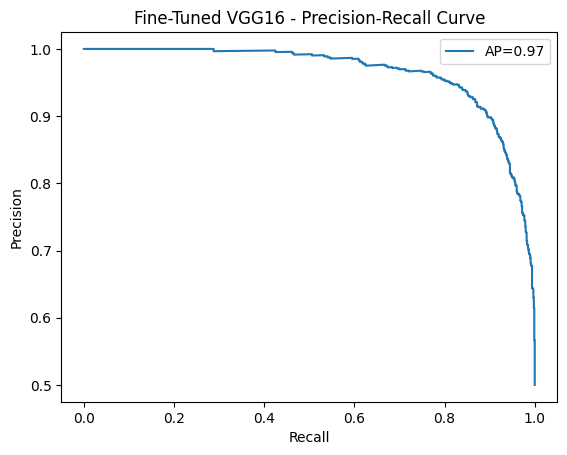

In [9]:
def evaluate_model(model, name):
    y_true = test_generator.classes
    y_pred = model.predict(test_generator).ravel()
    y_pred_label = (y_pred > 0.5).astype(int)

    print(f"--- {name} ---")
    print(classification_report(y_true, y_pred_label, target_names=['Cat', 'Dog']))

    cm = confusion_matrix(y_true, y_pred_label)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat','Dog'], yticklabels=['Cat','Dog'])
    plt.title(f'{name} - Confusion Matrix')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    ap = average_precision_score(y_true, y_pred)

    plt.plot(recall, precision, label=f'AP={ap:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{name} - Precision-Recall Curve')
    plt.legend()
    plt.show()

evaluate_model(model_cnn, "Custom CNN")
evaluate_model(model_vgg, "Fine-Tuned VGG16")


32/32 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step


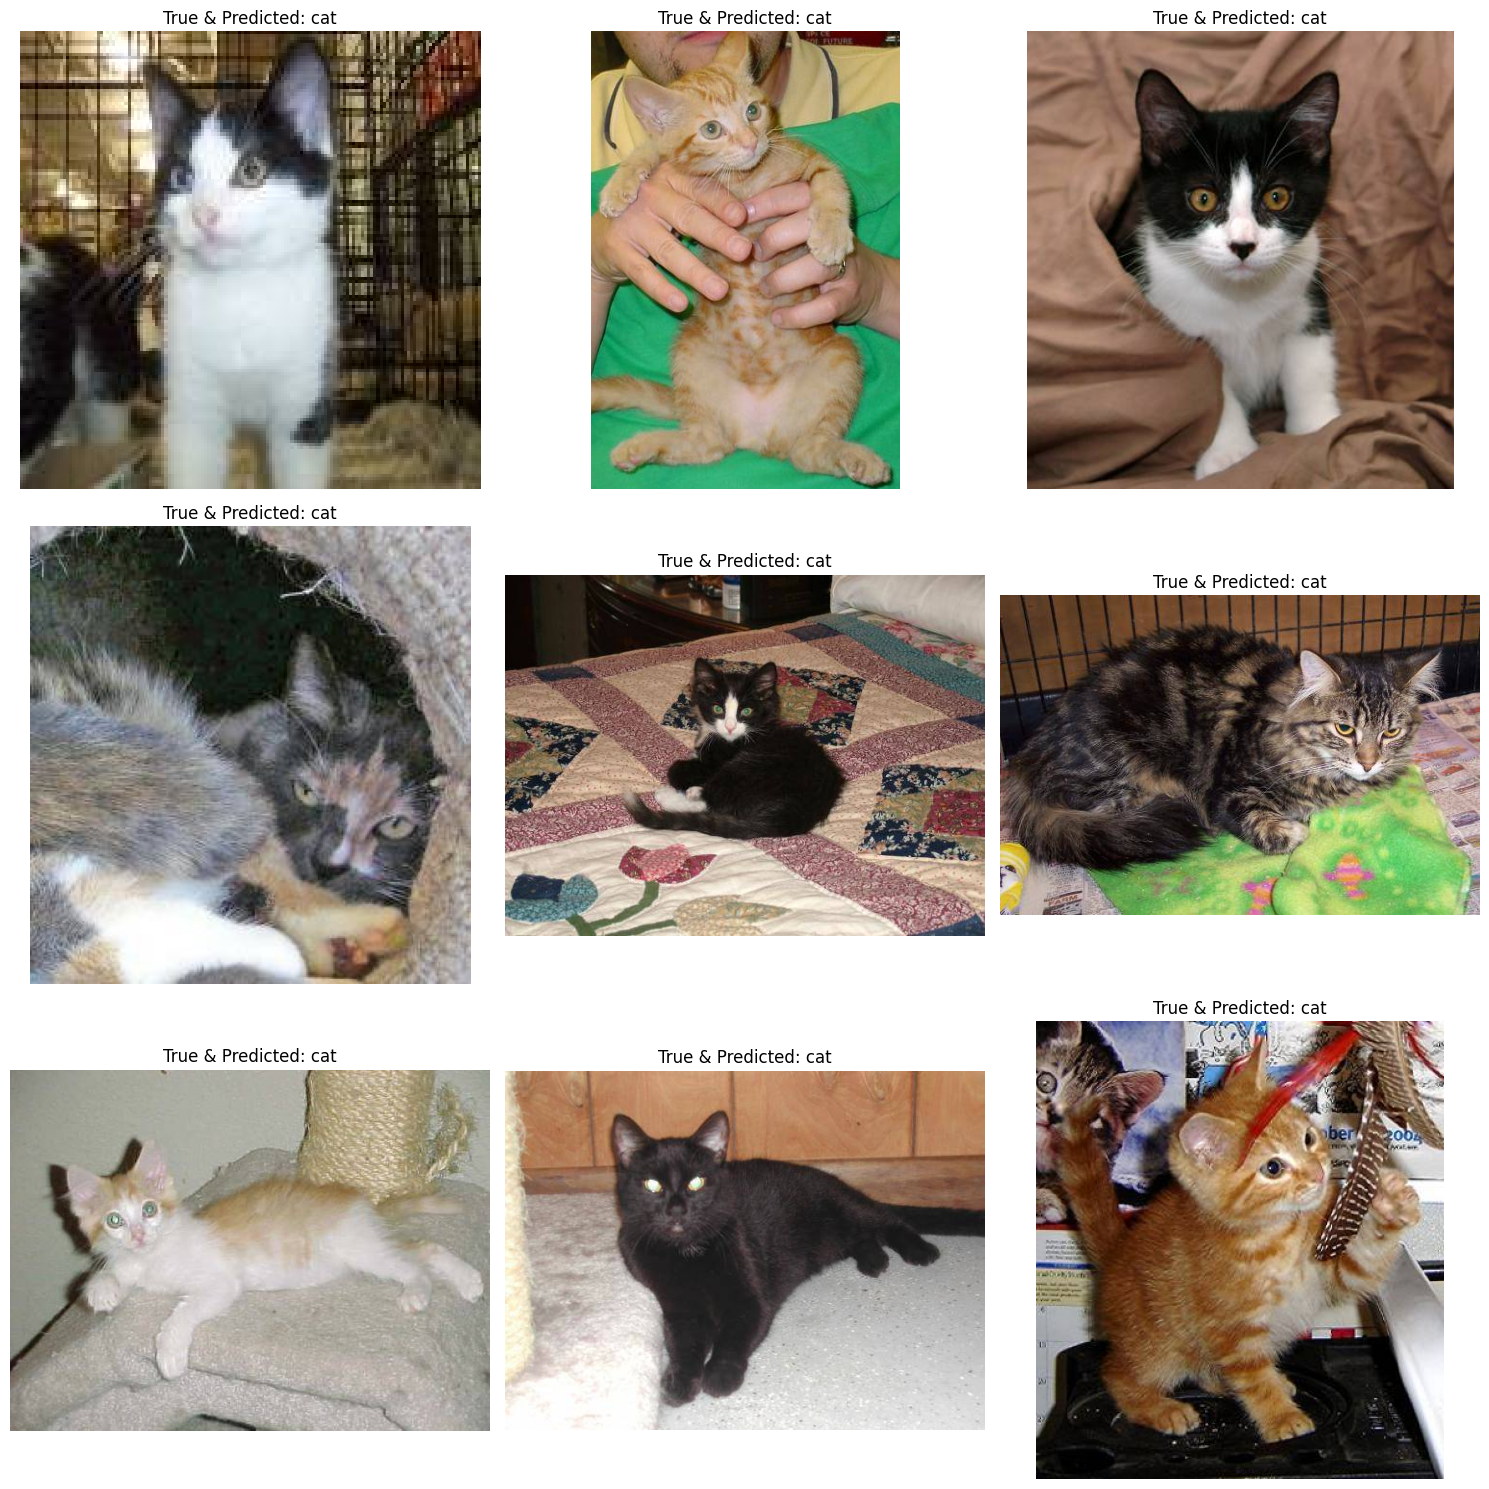

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Get predictions
validation_generator.reset()
preds = model_vgg.predict(validation_generator, verbose=1)
predicted_classes = np.argmax(preds, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Find correctly classified indices
correct_idx = np.where(predicted_classes == true_classes)[0]

# Display some correctly classified images
plt.figure(figsize=(15, 15))
for i, idx in enumerate(correct_idx[:9]):
    img_path = validation_generator.filepaths[idx]
    img = plt.imread(img_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"True & Predicted: {class_labels[true_classes[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


### Reflections and Observations 

### Custom CNN Model

- **Confusion Matrix**:
  - Cats: 607 correctly predicted, 393 misclassified as dogs.
  - Dogs: 829 correctly predicted, 171 misclassified as cats.
  
- **Precision-Recall Curve**: AP = 0.81

- **Metrics**:
  - Accuracy: **72%**
  - F1-score (weighted): **0.71**
  - Observation: The model struggles more with classifying cats.



### Fine-Tuned VGG16

- **Confusion Matrix**:
  - Cats: 890 correctly predicted, 110 misclassified.
  - Dogs: 908 correctly predicted, 92 misclassified.
  
- **Precision-Recall Curve**: AP = 0.97

- **Metrics**:
  - Accuracy: **90%**
  - F1-score (weighted): **0.90**
  - Observation: Much better balance and performance across both classes.



### Conclusion

The **Fine-Tuned VGG16** significantly outperforms the custom CNN model, offering:

- Higher overall accuracy
- Better precision and recall balance
- Fewer misclassifications

This suggests that transfer learning with a pre-trained model like VGG16 is highly effective for image classification tasks like distinguishing cats vs. dogs.


### Misclassification

32/32 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step


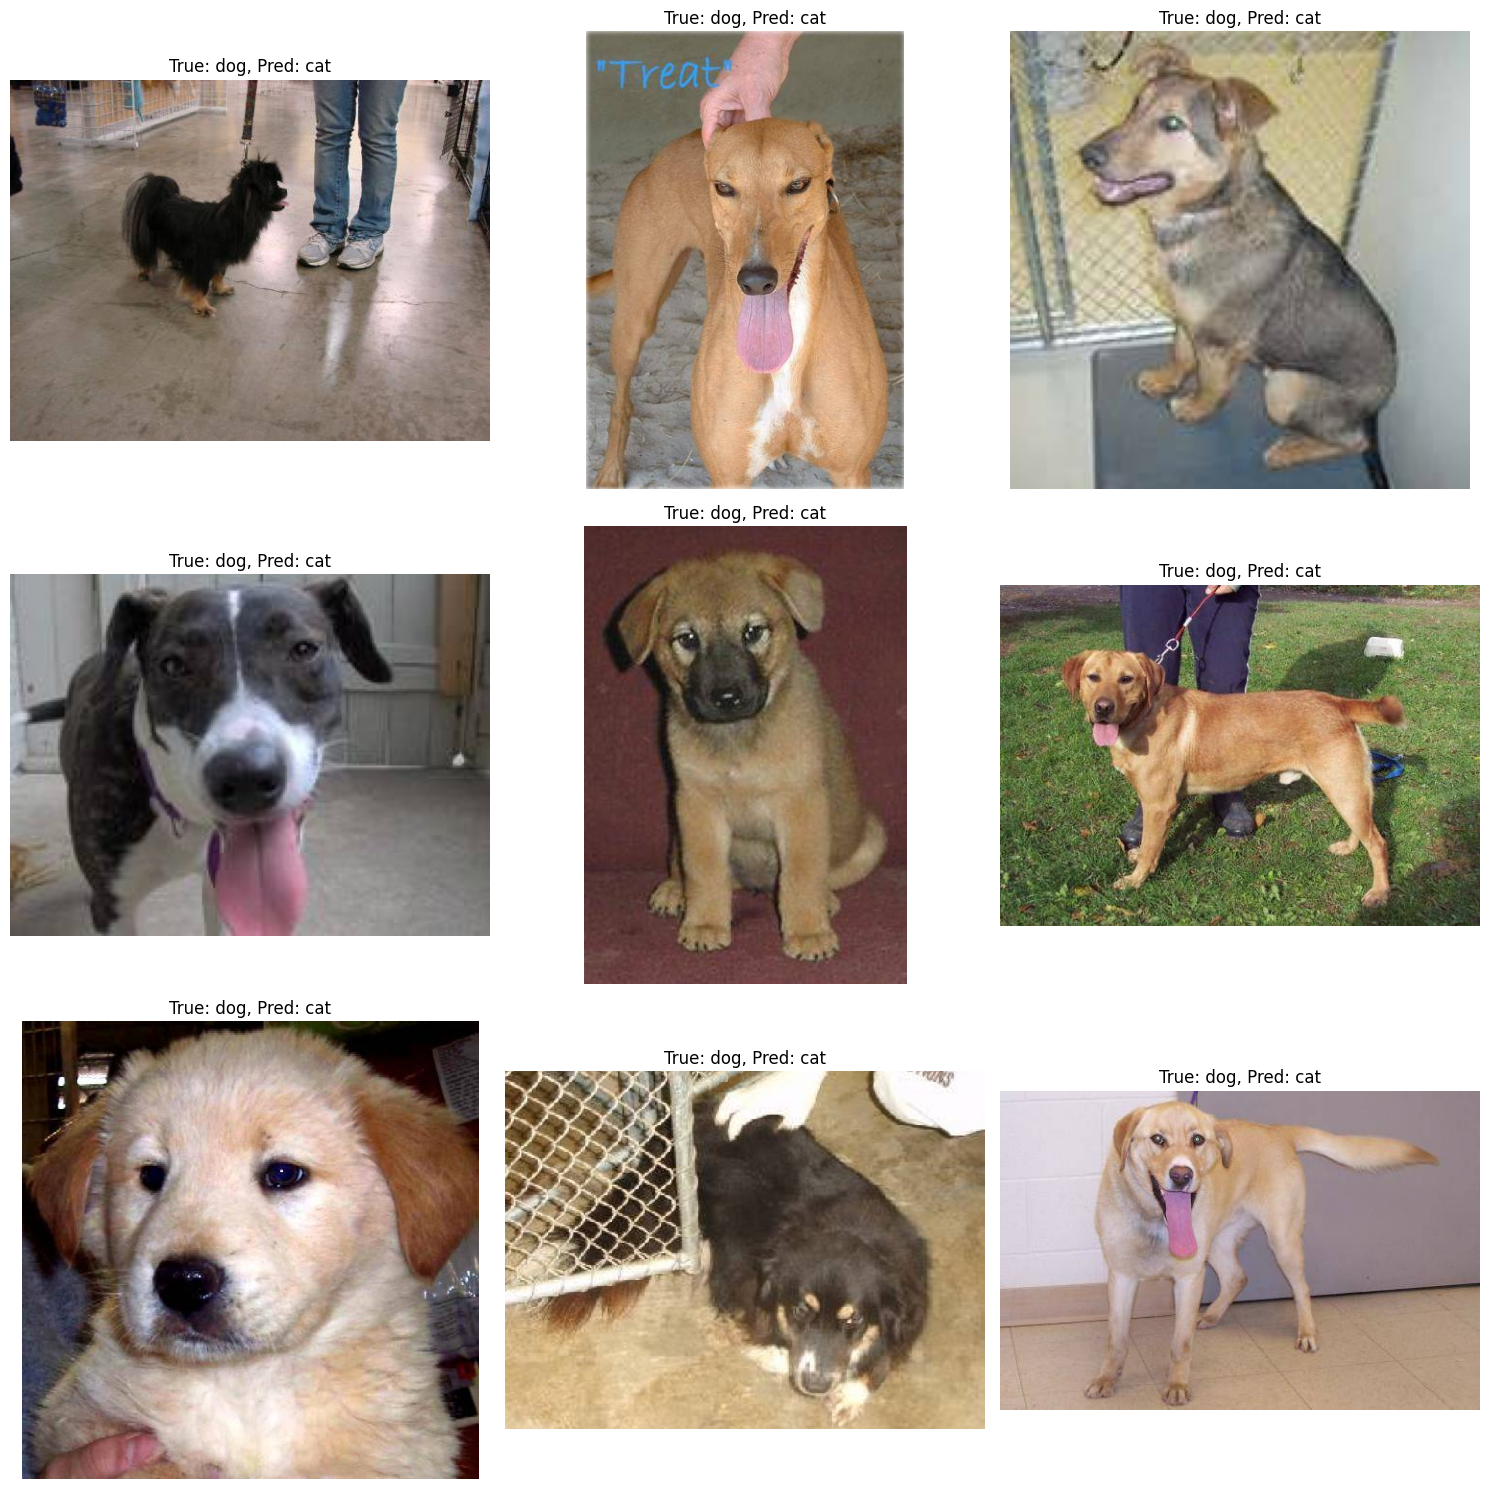

In [17]:

import numpy as np
import matplotlib.pyplot as plt

# Predict using the fine-tuned VGG16 model
validation_generator.reset()
preds = model_vgg.predict(validation_generator, verbose=1)
predicted_classes = np.argmax(preds, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Find misclassified indices
misclassified_idx = np.where(predicted_classes != true_classes)[0]

# Display some misclassified images
plt.figure(figsize=(15, 15))
for i, idx in enumerate(misclassified_idx[:9]):
    img_path = validation_generator.filepaths[idx]
    img = plt.imread(img_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"True: {class_labels[true_classes[idx]]}, Pred: {class_labels[predicted_classes[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


### Conclusion

 ### Final Conclusions

This project involved training and evaluating two models on a subset (5,000 images) of the **Dogs vs. Cats** dataset:

1. **Custom Convolutional Neural Network (CNN)**
2. **Fine-Tuned VGG16 (Pre-trained on ImageNet)**



#### Key Performance Summary:

- The **Fine-Tuned VGG16** significantly outperformed the Custom CNN in all evaluation metrics:
  - Accuracy: **90%** vs. **72%**
  - F1-Score (weighted): **0.90** vs. **0.71**
  - Average Precision (PR Curve): **0.97** vs. **0.81**

- **Confusion Matrices** show that VGG16 misclassified far fewer examples than the custom CNN.

#### Insights from Misclassifications:

By exploring examples the model got wrong, we observed that:

- Many misclassified **dogs were mistaken for cats**, especially:
  - **Puppies**, which may not resemble typical adult dogs in training data.
  - Dogs with **cat-like posture or facial features** (e.g., slender bodies, pointy ears).
  - Images with **unusual lighting, backgrounds**, or **low resolution**.
- This suggests that the model may struggle with **ambiguous or less common appearances** not well represented in the training set.


#### Recommendations and Improvements:

- **Enhance dataset diversity**: Add more varied images of dogs (puppies, different breeds, lighting conditions).
- **Use advanced augmentation**: Introduce augmentations simulating blur, scale, and lighting variation.
- **Visualize model attention**: Tools like Grad-CAM can reveal what parts of the image influenced predictions.
- **Experiment with better architectures**: Try EfficientNet, ResNet50, or ensemble models for improved generalization.



#### Conclusion:

This project demonstrates that **transfer learning with a pre-trained model like VGG16** can drastically improve performance in image classification, especially when working with a limited dataset. However, even strong models can fail in subtle, ambiguous cases—underscoring the importance of both quantitative evaluation and **qualitative error analysis**.
